# Try running analyses with more flexible IGM models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from cup1d.data import data_MPGADGET
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

### Emulator and training set

Create a set of training data to train an emulator

In [4]:
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [5]:
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

Training GP on 330 points


 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.39 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    #for par in ["tau"]:
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

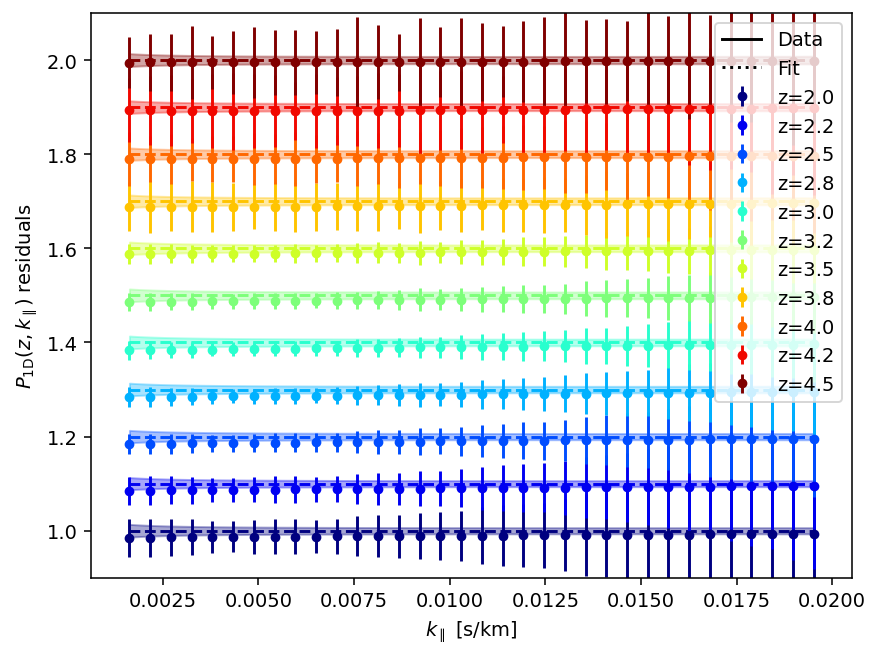

In [8]:
like.plot_p1d(residuals=True)

# Try iminuit minimizer

In [9]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [10]:
minimizer.minimize(compute_hesse=True)

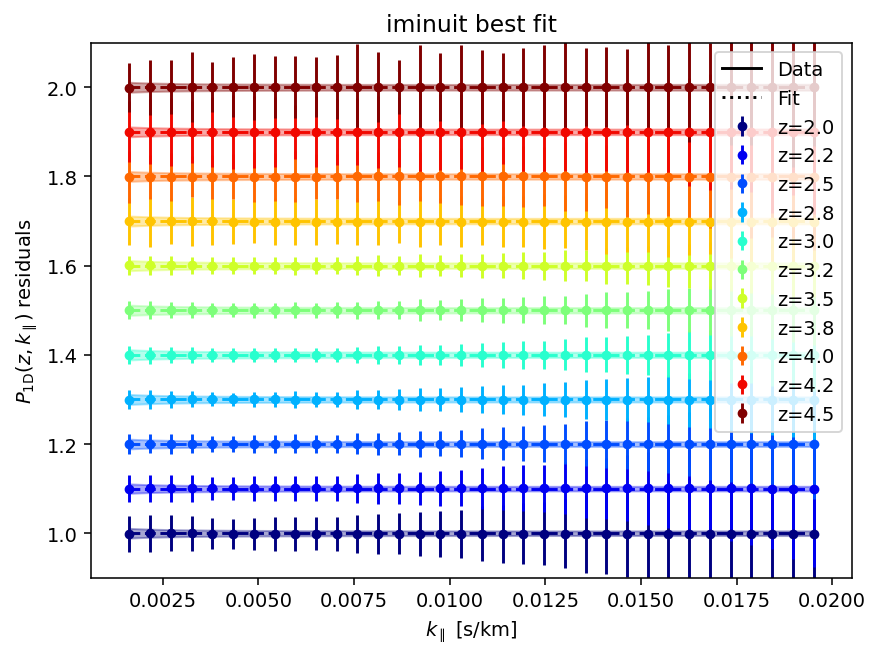

In [11]:
plt.figure()
minimizer.plot_best_fit()

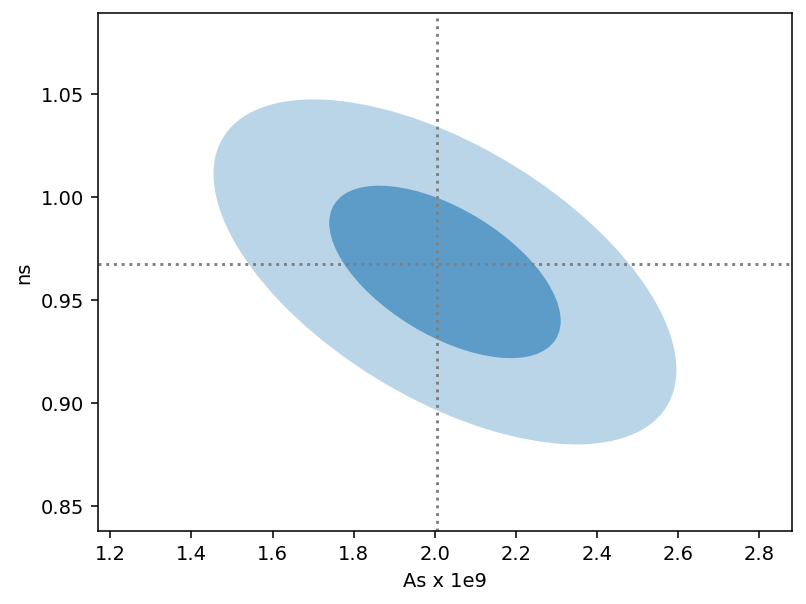

In [12]:
minimizer.plot_ellipses('As','ns')